In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import os
sys.path.append('..')

In [8]:
%load_ext autoreload
%autoreload 2
from lat_cb.signal import CMB, Foreground, Noise, LATsky,Mask, BandpassInt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

In [14]:
cmb = CMB(lib,1024,0.35)

In [17]:
E,B = hp.map2alm_spin(cmb.get_cb_lensed_QU(0),2)

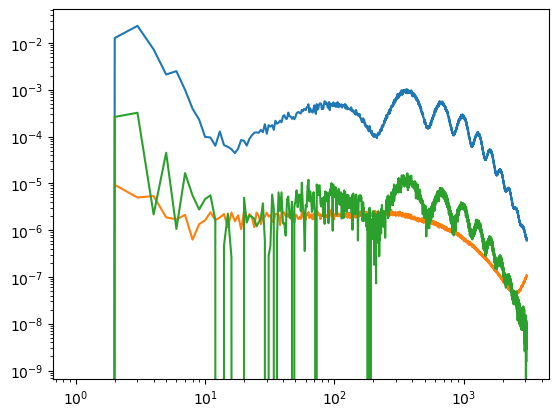

In [18]:
plt.loglog(hp.alm2cl(E),label='E')
plt.loglog(hp.alm2cl(B),label='B')
plt.loglog(hp.alm2cl(E,B),label='EB')

In [9]:
cmb.get_cb_lensed_QU(0)

array([[ 1.37486579,  3.62862544,  0.87852098, ...,  2.81340369,
        -4.16316575,  0.70300344],
       [-3.25501517, -1.14229384,  2.43514911, ..., -4.56932113,
         5.65956637,  1.12903113]])

In [19]:
freqs = LATsky.freqs
nlev_p = LATsky.nlevp

In [21]:
fg_wobp = Foreground(lib,512,1,1,bandpass=False)
fg_wbp = Foreground(lib,512,1,1,bandpass=True)

In [22]:
d1_wobp = fg_wobp.dustQU(280)
d1_wbp = fg_wbp.dustQU(280)

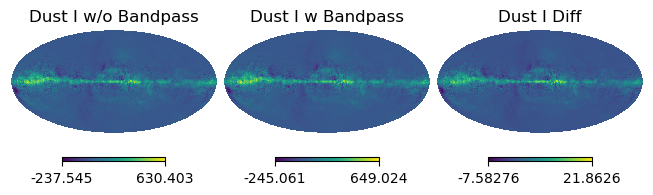

In [25]:
hp.mollview(d1_wobp[0],title='Dust I w/o Bandpass',sub=(1,3,1))
hp.mollview(d1_wbp[0],title='Dust I w Bandpass',sub=(1,3,2))
hp.mollview(d1_wbp[0]-d1_wobp[0],title='Dust I Diff',sub=(1,3,3))

In [12]:
for f in freqs:
    q = fg.dustQU(f)

In [13]:
for f in freqs:
    q = fg.syncQU(f)

In [14]:
n = Noise(512)

In [15]:
nc = n.noiseQU(nlev_p[0])

In [17]:
beta = [0.1,0.1,0.8,0.8,.2,.2]

In [18]:
lat = LATsky(lib,512,0.35,1,1,beta)

In [19]:
lat.config

{27: {'fwhm': 7.4, 'nlevp': 71, 'beta': 0.1},
 39: {'fwhm': 5.1, 'nlevp': 36, 'beta': 0.1},
 93: {'fwhm': 2.2, 'nlevp': 8, 'beta': 0.8},
 145: {'fwhm': 1.4, 'nlevp': 10, 'beta': 0.8},
 225: {'fwhm': 1.0, 'nlevp': 22, 'beta': 0.2},
 280: {'fwhm': 0.9, 'nlevp': 54, 'beta': 0.2}}

In [20]:
for f in LATsky.freqs:
    q = lat.obsQU(1,f)

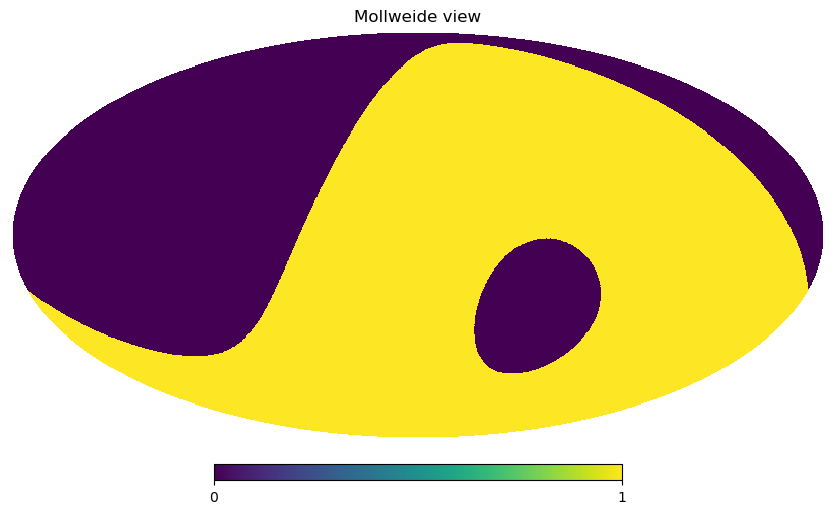

In [21]:
hp.mollview(lat.mask)

In [9]:
bp = BandpassInt()

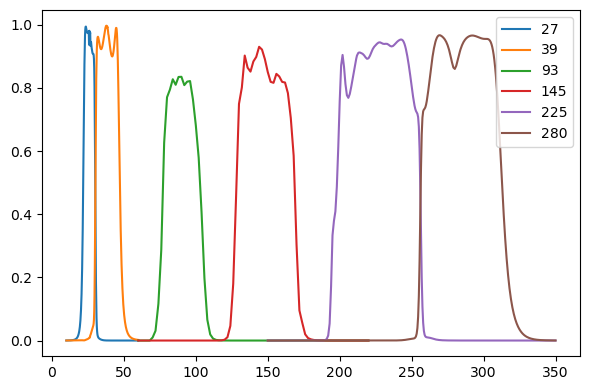

In [13]:
bp.plot_profiles()